# Embedded ML Lab - Excercise 0 - Intro Training

Now that we have covered Neural Network Inference, we come to the training of neural networks. We reuse the LeNet from the previous exercise.

<span style="color:green">Your Task:</span>
* <span style="color:green">Copy your implementation of the LeNet from the last excercise into Cell1</span>

In Cell 2 the dataset is already prepared as a dataloader (using batch_size 32). Additionally, the images are already zero-centered and normalized. We have two separate data_loaders: `test_loader` for testing the accuracy of the model, and `train_data` for training the model. These two should not be mixed for their tasks. You can iterate over the batches of a dataloader by using `for idx, (input, targets) in enumerate(dataloader):`

Before we start with training, we need to write two functions. The first is `correct_predictions(outputs, targets)`, where you can reuse code from exercise_00. This function takes the outputs and targets as input and returns an int with the number of correct predictions in the batch. 
The second function `test_net(net, device)`. This function iterates over the testloader, applies the network's forward pass, and returns the overall accuracy of the model (all correct predictions of the testset overall testset predictions)

<span style="color:green">Your Tasks:</span>
* <span style="color:green">Implement the `correct_predictions` function (Cell 3)</span>
* <span style="color:green">Implement the `test_net` function (Cell 4)</span>
    * <span style="color:green">First set the network in evaluation mode with `.eval()` </span>
    * <span style="color:green">Iterate over the batches in the dataloader</span>
    * <span style="color:green">For each batch calculate the correct detected images</span>
    * NOTE: you can also only iterate over a fraction of batches to save some time
    * <span style="color:green">Return the overall Accuracy</span>

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        #---to-be-done-by-student---
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(400,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)   
        #---end---------------------
        return
    
    def forward(self,x):
        #---to-be-done-by-student---
        tmp = self.conv1(x)
        tmp = F.relu(tmp)
        tmp = F.max_pool2d(tmp,2)
        tmp = self.conv2(tmp)
        tmp = F.relu(tmp)
        tmp = F.max_pool2d(tmp,2)
        tmp = tmp.flatten(start_dim=1) #passt jetzt
        tmp = self.fc1(tmp)
        tmp = F.relu(tmp)
        tmp = self.fc2(tmp)
        tmp = F.relu(tmp)
        tmp = self.fc3(tmp)
        
        #---end---------------------
        return tmp

net = LeNet()

In [14]:
import torchvision
import time

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('.', train=False, download=True, transform=torchvision.transforms.Compose([
                                                torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(
                                                (0.1307, ), (0.3081)) ])), batch_size=64, shuffle=False, drop_last=True)

train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('.', train=True, download=True, transform=torchvision.transforms.Compose([
                                                torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(
                                                (0.1307, ), (0.3081)) ])), batch_size=64, shuffle=False, drop_last=True)

print(len(train_loader))

937


In [15]:
def correct_predictions(outputs, targets):
    correct_predictions = 0
    #---to-be-done-by-student---
    _, predicted = torch.max(outputs, 1)
    correct_predictions = (predicted == targets).sum().item()
    #---end---------------------
    return correct_predictions

In [23]:
def test_net(net, device):
    #---to-be-done-by-student---
    net.eval()  # set the network to evaluation mode
    correct_detected = 0
    overall = 0
    
    with torch.no_grad():  # disable gradient calculation during inference
        for idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            correct_detected += correct_predictions(outputs, targets)
            overall += targets.size(0)
        
            
    #---end---------------------
    print(overall)
    return float(correct_detected/overall)

Now that we have these two helper functions we come to training the network. Some parts are already given. You can do the training either on the cpu or on the gpu (gpu should be faster).

First we define an optimizer `optimizer = torch.optim.SGD(net.parameters(), lr=0.01)` and hand in the model's parameters (e.g., weights and biases of the conv and linear layers). Besides the model's parameters, we set the learning rate to 0.01. The learning defines the step size for updating the parameters based on their gradients.

Also, we require a loss function `loss_function = nn.CrossEntropyLoss()`, which defines the error (loss) between the output of the network and the desired output target.
To train the network we iterate over the dataset several times (for 5 epochs).

We can split the training into five parts (for each training batch):   
<span style="color:green">Your Tasks:</span>   
* <span style="color:green">**Clean old gradients**: Remove the previous gradients of the parameters by calling `optimizer.zero_grad()`.</span>   
* <span style="color:green">**Forward Pass**: Similar to the previous inference experiments, 
    calculate the network's output.</span>   
* <span style="color:green">**Loss**: Calculate the loss by using `loss_function(outputs, targets)`.</span>   
* <span style="color:green">**Backpropagation of the error**: Call `.backward()` on the loss tensor and Pytorch will automatically calculate the respective gradients of the modules with respect to the input and parameters.</span>
* <span style="color:green">**Step**: As the last step, modify the parameters based on their gradients by calling `optimizer.step()`.</span>

Plotting the accuracy and loss of the model:

<span style="color:green">Your Tasks:</span> 
* <span style="color:green">Collect the network's loss for each batch.
* <span style="color:green">After every 100 batches calculate the networks average_loss (of last 100 batches).</span>
* <span style="color:green">Similar, calculate the models accuracy using using your defined `test_net` function.</span>
* <span style="color:green">Append the average loss and the accuracy to `loss_list` and `acc_list`, respectively.</span>

In [20]:
n_epochs = 5
loss_list = []
acc_list = []

net = LeNet()
device = torch.device('cuda')

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
loss_function = nn.CrossEntropyLoss()
net.to(device)
#---to-be-done-by-student---
loss_sum = 0.0
#---end---------------------

for epoch_n in range(n_epochs):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        #---to-be-done-by-student---
        
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = net(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        #---end---------------------
        if batch_idx % 100 == 0 and batch_idx != 0:
            
            #---to-be-done-by-student---
            average_loss = loss_sum/100
            test_accuracy = test_net(net, device)
            loss_list.append(average_loss)
            acc_list.append(test_accuracy)
            print(f"Epoch [{epoch_n + 1}/{n_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {average_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
            loss_sum = 0.0
            
            #---end---------------------

Epoch [1/5], Batch [101/937], Loss: 2.3046, Test Accuracy: 0.2964
Epoch [1/5], Batch [201/937], Loss: 2.1803, Test Accuracy: 0.5186
Epoch [1/5], Batch [301/937], Loss: 1.6100, Test Accuracy: 0.6887
Epoch [1/5], Batch [401/937], Loss: 0.7778, Test Accuracy: 0.7855
Epoch [1/5], Batch [501/937], Loss: 0.5867, Test Accuracy: 0.8625
Epoch [1/5], Batch [601/937], Loss: 0.4618, Test Accuracy: 0.8908
Epoch [1/5], Batch [701/937], Loss: 0.4252, Test Accuracy: 0.8784
Epoch [1/5], Batch [801/937], Loss: 0.3842, Test Accuracy: 0.8884
Epoch [1/5], Batch [901/937], Loss: 0.3227, Test Accuracy: 0.9106
Epoch [2/5], Batch [101/937], Loss: 0.3922, Test Accuracy: 0.8972
Epoch [2/5], Batch [201/937], Loss: 0.3066, Test Accuracy: 0.9222
Epoch [2/5], Batch [301/937], Loss: 0.2842, Test Accuracy: 0.8970
Epoch [2/5], Batch [401/937], Loss: 0.2427, Test Accuracy: 0.9310
Epoch [2/5], Batch [501/937], Loss: 0.2510, Test Accuracy: 0.9366
Epoch [2/5], Batch [601/937], Loss: 0.2092, Test Accuracy: 0.9417
Epoch [2/5

Text(0.5, 1.0, 'LeNet training')

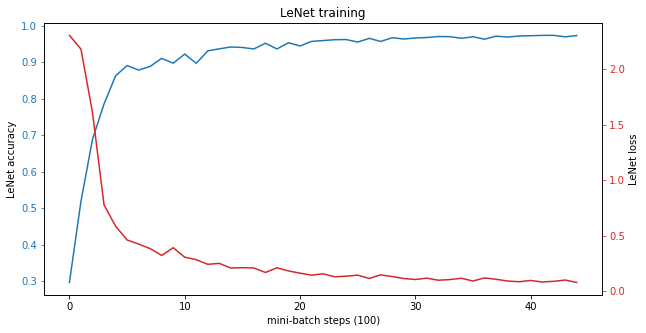

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [10, 5]

fig, ax = plt.subplots(1)

ax.plot(np.array(acc_list), color='tab:blue')
ax.set_xlabel('mini-batch steps (100)')
ax.set_ylabel('LeNet accuracy')
ax.tick_params(colors='tab:blue', axis='y')

ax2 = ax.twinx()
ax2.plot(np.array(loss_list), color='tab:red')
ax2.set_ylabel('LeNet loss')
ax2.tick_params(colors='tab:red', axis='y')
ax.set_title('LeNet training')

You can save your training state by using `state_dict = net.state_dict()` and `torch.save(state_dict, 'lenet_new.pt')`

<span style="color:green">Your Task:</span>   
* <span style="color:green">Save the state dict of the model with a new name and plug it into exercise 01 by changing the file name in Cell 9</span>

In [24]:
#save model here
#---to-be-done-by-student---
state_dict = net.state_dict()
torch.save(state_dict, 'lenet_new.pt')
#---end---------------------